In [1]:
#Loads all required libraries for images, data handling, plotting, and PyTorch.
#Sets random seeds for reproducible results and selects the device (CPU or GPU).

import os
from pathlib import Path
import math
import random
import time

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make matplotlib plots a bit nicer
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [2]:
# We set the paths to your image folder and CSV file, loads the CSV, checks that the required columns exist, and removes any rows with missing values.
#It prints the first rows so you can confirm the data looks correct.

from pathlib import Path
import pandas as pd



DATA_ROOT = Path("data")
SESSION   = "all_sessions_raw"

IMG_DIR   = DATA_ROOT / SESSION                # Folder with images
CSV_PATH  = IMG_DIR / "all_sessions_labels_v2.csv"

print("IMG_DIR :", IMG_DIR.resolve())
print("CSV_PATH:", CSV_PATH.resolve())

assert IMG_DIR.is_dir(),  f"Image folder not found: {IMG_DIR.resolve()}"
assert CSV_PATH.is_file(), f"CSV file not found: {CSV_PATH.resolve()}"

# Load CSV
df = pd.read_csv(CSV_PATH)

print("\nColumns in CSV:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
display(df.head())

# >>> CHANGE THESE TWO NAMES to match your CSV <<<
IMAGE_COLUMN = "filename"      # e.g. "filename" or "image_path"
ANGLE_COLUMN = "angle_deg"     # e.g. "angle_deg" or "steering_angle"

assert IMAGE_COLUMN in df.columns, f"{IMAGE_COLUMN} not in CSV"
assert ANGLE_COLUMN in df.columns, f"{ANGLE_COLUMN} not in CSV"

# Basic cleaning: drop NaNs
df = df.dropna(subset=[IMAGE_COLUMN, ANGLE_COLUMN]).reset_index(drop=True)
print("\nAfter dropping NaNs, number of rows:", len(df))
display(df[[IMAGE_COLUMN, ANGLE_COLUMN]].head(1000))


IMG_DIR : /data/home/s25076817/notebooks/data/all_sessions_raw
CSV_PATH: /data/home/s25076817/notebooks/data/all_sessions_raw/all_sessions_labels_v2.csv

Columns in CSV:
['filename', 'angle_deg']

First 5 rows:


,filename,angle_deg
0,img_000001.jpg,-52.625696
1,img_000012.jpg,-3.000000
2,img_000013.jpg,-67.435526
3,img_000014.jpg,-71.085469
4,img_000015.jpg,-27.796918



After dropping NaNs, number of rows: 3723


,filename,angle_deg
0,img_000001.jpg,-52.625696
1,img_000012.jpg,-3.000000
2,img_000013.jpg,-67.435526
3,img_000014.jpg,-71.085469
4,img_000015.jpg,-27.796918


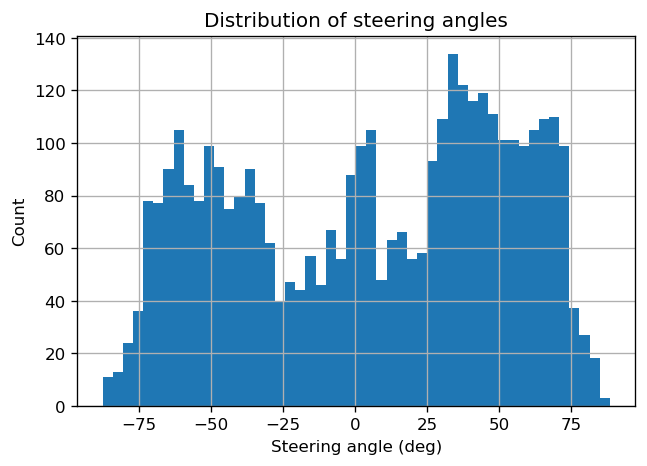

Min angle: -87.67246361704235
Max angle: 88.46974137172259
Mean angle: 5.375363613646788
Std angle : 46.833084246168966


In [3]:
#Ploting a histogram of all steering angles and prints their min, max, mean, and standard deviation, so you can see how the target values are spread

angles = df[ANGLE_COLUMN].astype(float).values

plt.hist(angles, bins=50)
plt.xlabel("Steering angle (deg)")
plt.ylabel("Count")
plt.title("Distribution of steering angles")
plt.grid(True)
plt.show()

print("Min angle:", angles.min())
print("Max angle:", angles.max())
print("Mean angle:", angles.mean())
print("Std angle :", angles.std())


In [5]:
#Updating the Dataset so it only keeps samples where the image file actually exists. 
#This prevents errors during training. It then prints how many valid samples were found and checks that one sample loads correctly

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import torch
import os

class SteeringDataset(Dataset):
    """
    Dataset that:
    - reads rows from df
    - builds a list of ONLY valid (img_path, angle) pairs at __init__
    - so __getitem__ never hits a missing file.
    """
    def __init__(self, dataframe, img_dir, image_column, angle_column,
                 img_height=66, img_width=200):
        self.img_dir = Path(img_dir)
        self.img_height = img_height
        self.img_width = img_width

        self.transform = T.Compose([
            T.Resize((self.img_height, self.img_width)),
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5]),
        ])

        self.samples = []  # list of (Path, angle)
        missing_count = 0

        for _, row in dataframe.iterrows():
            raw_path = str(row[image_column])
            filename = os.path.basename(raw_path)     
            img_path = self.img_dir / filename       

            if not img_path.exists():
                missing_count += 1
                continue  # skip this row

            angle = float(row[angle_column])
            self.samples.append((img_path, angle))

        if len(self.samples) == 0:
            raise RuntimeError("SteeringDataset has 0 valid samples. Check paths/columns.")

        print(f"SteeringDataset: {len(self.samples)} valid samples, "
              f"skipped {missing_count} missing images.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, angle = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        angle_tensor = torch.tensor([angle], dtype=torch.float32)
        return image, angle_tensor

# Sanity check
IMG_HEIGHT = 66
IMG_WIDTH = 200

test_dataset_tmp = SteeringDataset(
    df,
    IMG_DIR,
    IMAGE_COLUMN,
    ANGLE_COLUMN,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
)

print("Dataset length:", len(test_dataset_tmp))
img_sample, angle_sample = test_dataset_tmp[0]
print("One image shape:", img_sample.shape)  # should be [3, 66, 200]
print("One angle:", angle_sample)


SteeringDataset: 3723 valid samples, skipped 0 missing images.
Dataset length: 3723
One image shape: torch.Size([3, 66, 200])
One angle: tensor([-52.6257])


In [6]:
#Spliting the cleaned dataframe into train, validation, and test sets, prints how many samples are in each split, and then creates PyTorch DataLoaders for them with a chosen batch size

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=SEED, shuffle=True)
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, shuffle=True)

print(f"Train rows: {len(train_df)}")
print(f"Val rows:   {len(val_df)}")
print(f"Test rows:  {len(test_df)}")

train_dataset = SteeringDataset(train_df, IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
                                img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
val_dataset   = SteeringDataset(val_df,   IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
                                img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
test_dataset  = SteeringDataset(test_df,  IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
                                img_height=IMG_HEIGHT, img_width=IMG_WIDTH)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Train rows: 2606
Val rows:   558
Test rows:  559
SteeringDataset: 2606 valid samples, skipped 0 missing images.
SteeringDataset: 558 valid samples, skipped 0 missing images.
SteeringDataset: 559 valid samples, skipped 0 missing images.


In [7]:
#Here creating the CNN we use to predict the steering angle. It lets us choose how many convolution layers the model should have, builds the network,
#and then prints a sample version of it to make sure the structure is correct.

class SteeringCNNDepth(nn.Module):
    def __init__(self, img_height=66, img_width=200, in_channels=3,
                 num_conv_layers=3):
        super().__init__()
        assert 1 <= num_conv_layers <= 5, 

        layers = []
        channels_in = in_channels

        # Block 1
        layers += [
            nn.Conv2d(channels_in, 24, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
        ]
        channels_in = 24

        # Block 2
        layers += [
            nn.Conv2d(channels_in, 36, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(36),
            nn.ReLU(inplace=True),
        ]
        channels_in = 36

        # Block 3
        layers += [
            nn.Conv2d(channels_in, 48, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        ]
        channels_in = 48

        # Block 4
        layers += [
            nn.Conv2d(channels_in, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        ]
        channels_in = 64

        # Block 5
        layers += [
            nn.Conv2d(channels_in, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        ]
        channels_in = 64

        # Keep only as many blocks as requested (each block = 3 modules)
        num_modules_to_keep = num_conv_layers * 3
        self.features = nn.Sequential(*layers[:num_modules_to_keep])

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Determine flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_height, img_width)
            x = self.features(dummy)
            x = self.pool(x)
            flat_dim = x.view(1, -1).shape[1]

        self.regressor = nn.Sequential(
            nn.Linear(flat_dim, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(50, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x

# small sanity print
tmp_model = SteeringCNNDepth(img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
                             in_channels=3, num_conv_layers=3).to(DEVICE)
print(tmp_model)


SteeringCNNDepth(
  (features): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (regressor): Sequential(
    (0): Linear(in_features=2304, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6)

In [8]:
# two helper functions used during training.
#The first one trains the model for one full pass over the data, and the second one evaluates the model on validation or test data while also computing metrics such as MAE, RMSE, and R²

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for images, angles in dataloader:
        images = images.to(DEVICE, non_blocking=True)
        angles = angles.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    preds = []
    targets = []

    with torch.no_grad():
        for images, angles in dataloader:
            images = images.to(DEVICE, non_blocking=True)
            angles = angles.to(DEVICE, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, angles)

            running_loss += loss.item() * images.size(0)

            preds.append(outputs.cpu().numpy())
            targets.append(angles.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)

    mae = mean_absolute_error(targets, preds)
    rmse = math.sqrt(mean_squared_error(targets, preds))
    r2 = r2_score(targets, preds)

    return loss, mae, rmse, r2, preds, targets


In [9]:
# train the CNN five times, each time using a different number of convolution layers (from 1 to 5). For every model, 
#it records the training and validation performance, saves the best version, evaluates it on the test set, 
#and then stores all results in a table so we can compare which depth works best

results = []
histories = {}

criterion = nn.MSELoss()
LR = 1e-3
EPOCHS = 20

for depth in [1, 2, 3, 4, 5]:
    print("=" * 80)
    print(f"Depth {depth} – training")
    print("=" * 80)

    model = SteeringCNNDepth(img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
                             in_channels=3, num_conv_layers=depth).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

    train_losses, val_losses, val_rmses = [], [], []
    best_val_rmse = float("inf")
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_mae, val_rmse, val_r2, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_rmses.append(val_rmse)

        print(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train: {train_loss:.4f} | "
            f"Val: {val_loss:.4f} | "
            f"Val RMSE: {val_rmse:.4f} | "
            f"Val R2: {val_r2:.4f}"
        )

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_state = model.state_dict()

    histories[depth] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_rmses": val_rmses,
        "best_val_rmse": best_val_rmse,
        "best_state": best_state,
    }

    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss, test_mae, test_rmse, test_r2, _, _ = evaluate(model, test_loader, criterion)

    results.append({
        "depth": depth,
        "lr": LR,
        "epochs": EPOCHS,
        "best_val_rmse": best_val_rmse,
        "test_loss": test_loss,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values("test_rmse"))


Depth 1 – training
Epoch 01/20 | Train: 1039.9284 | Val: 307.9492 | Val RMSE: 17.5485 | Val R2: 0.8579
Epoch 02/20 | Train: 267.5191 | Val: 119.1549 | Val RMSE: 10.9158 | Val R2: 0.9450
Epoch 03/20 | Train: 217.5405 | Val: 185.7408 | Val RMSE: 13.6287 | Val R2: 0.9143
Epoch 04/20 | Train: 168.3485 | Val: 99.1609 | Val RMSE: 9.9580 | Val R2: 0.9542
Epoch 05/20 | Train: 149.7536 | Val: 80.8418 | Val RMSE: 8.9912 | Val R2: 0.9627
Epoch 06/20 | Train: 144.5413 | Val: 99.5632 | Val RMSE: 9.9781 | Val R2: 0.9540
Epoch 07/20 | Train: 136.6648 | Val: 69.4887 | Val RMSE: 8.3360 | Val R2: 0.9679
Epoch 08/20 | Train: 141.3109 | Val: 108.5429 | Val RMSE: 10.4184 | Val R2: 0.9499
Epoch 09/20 | Train: 122.6880 | Val: 73.8933 | Val RMSE: 8.5961 | Val R2: 0.9659
Epoch 10/20 | Train: 124.3947 | Val: 70.2740 | Val RMSE: 8.3830 | Val R2: 0.9676
Epoch 11/20 | Train: 120.4233 | Val: 71.0513 | Val RMSE: 8.4292 | Val R2: 0.9672
Epoch 12/20 | Train: 112.4523 | Val: 83.6259 | Val RMSE: 9.1447 | Val R2: 0.9614


,depth,lr,epochs,best_val_rmse,test_loss,test_mae,test_rmse,test_r2
4,5,0.001,20,5.454448,38.884338,3.378637,6.235730,0.982064
3,4,0.001,20,6.217108,53.513151,4.552518,7.315268,0.975316
2,3,0.001,20,5.960389,97.232208,7.328988,9.860639,0.955150
1,2,0.001,20,6.614618,97.241321,6.798727,9.861101,0.955146
0,1,0.001,20,7.905354,130.721783,8.038434,11.433363,0.939702


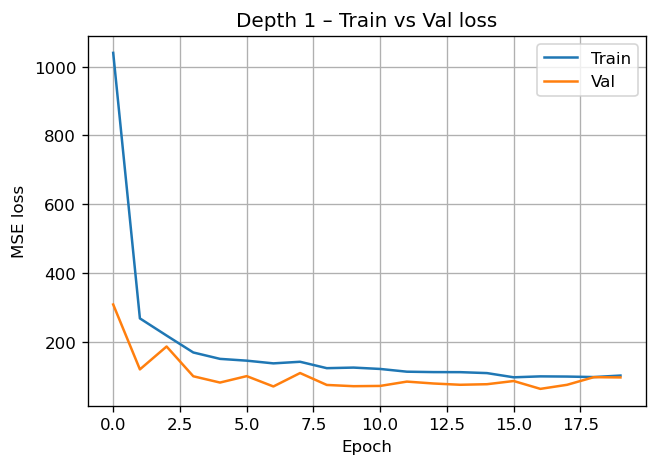

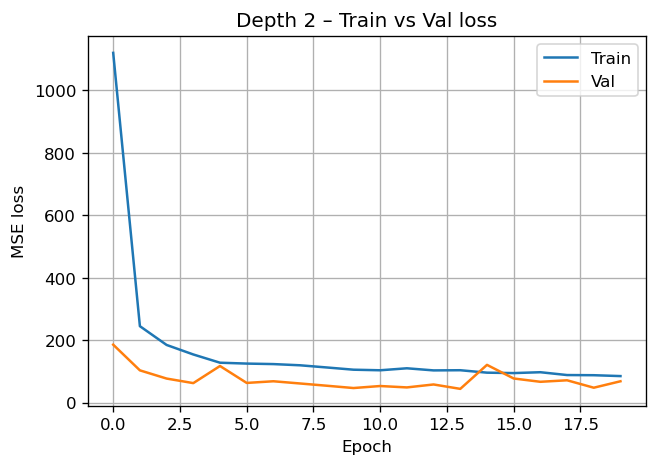

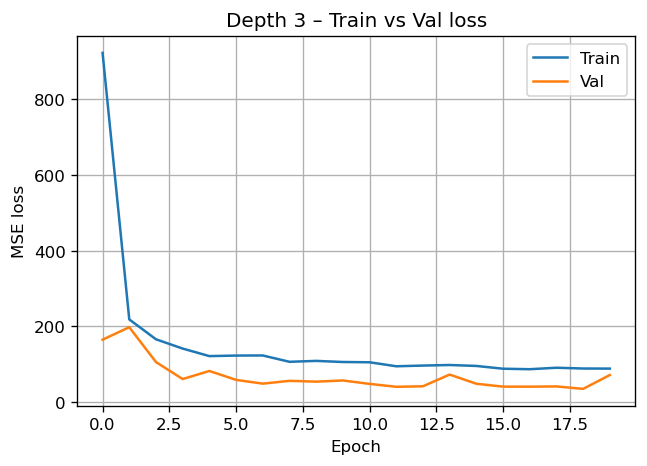

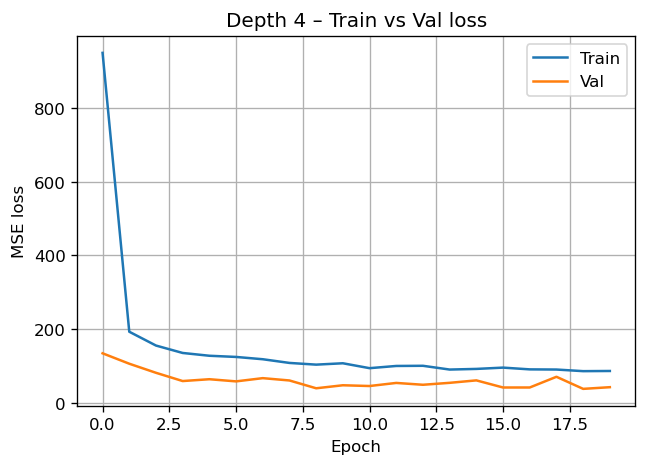

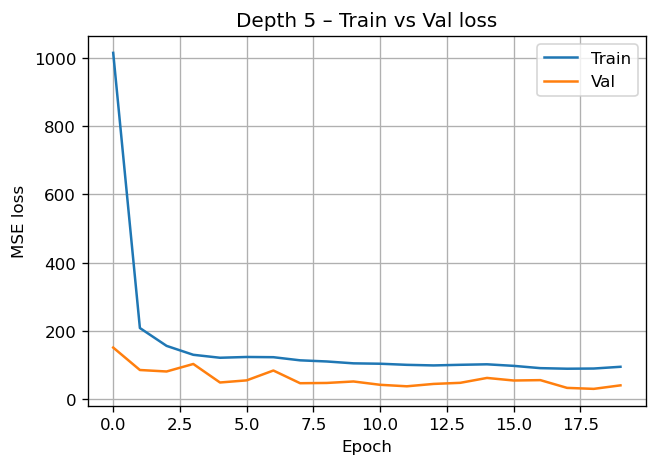

In [10]:
# creating a plot for each model depth, showing how the training and validation loss changed over the epochs so we can see how well each model learned

for depth in [1, 2, 3, 4, 5]:
    h = histories[depth]
    plt.figure()
    plt.plot(h["train_losses"], label="Train")
    plt.plot(h["val_losses"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title(f"Depth {depth} – Train vs Val loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
#The validation set is smaller and more stable, and the model is evaluated in a fixed state, which often makes the validation curve smoother and sometimes lower.
#Overall, this simply shows that the model is learning consistently, and deeper models handle the task better.
#he validation set is simply easier or cleaner than the training set, so its loss appears lower

Best depth: 5
depth             5.000000
lr                0.001000
epochs           20.000000
best_val_rmse     5.454448
test_loss        38.884338
test_mae          3.378637
test_rmse         6.235730
test_r2           0.982064
Name: 4, dtype: float64

Best depth: 5
Test Loss: 38.8843
Test MAE : 3.3786
Test RMSE: 6.2357
Test R2  : 0.9821


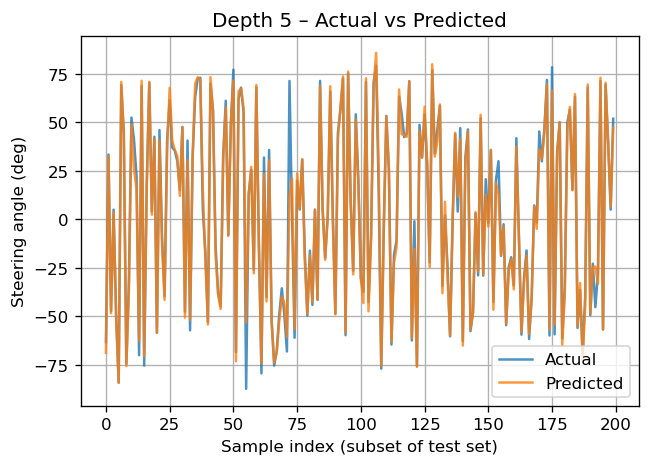

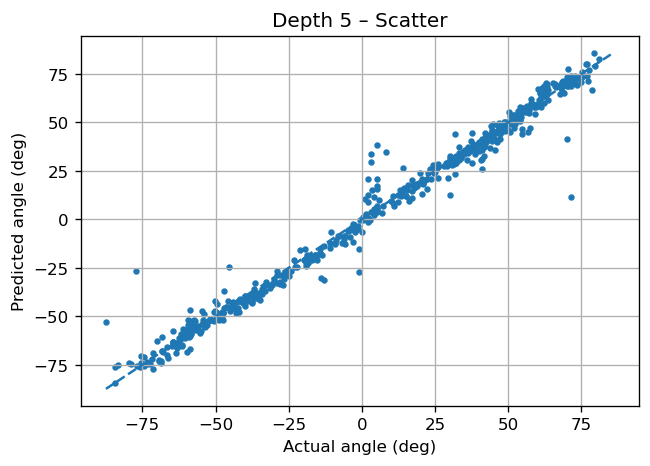

In [11]:
# finding which version of the model (which depth) worked the best. It then loads that model, tests it on the test set, 
#prints the final scores, and shows two simple plots comparing the model’s predicted angles to the real angles so we can see how well it performs

best_row = results_df.sort_values("test_rmse").iloc[0]
best_depth = int(best_row["depth"])
print("Best depth:", best_depth)
print(best_row)

best_model = SteeringCNNDepth(img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
                              in_channels=3, num_conv_layers=best_depth).to(DEVICE)
best_model.load_state_dict(histories[best_depth]["best_state"])

test_loss, test_mae, test_rmse, test_r2, preds, targets = evaluate(
    best_model, test_loader, criterion
)

print(f"\nBest depth: {best_depth}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE : {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2  : {test_r2:.4f}")

# line plot for first 200 samples
plt.figure()
plt.plot(targets[:200], label="Actual", alpha=0.8)
plt.plot(preds[:200],   label="Predicted", alpha=0.8)
plt.xlabel("Sample index (subset of test set)")
plt.ylabel("Steering angle (deg)")
plt.title(f"Depth {best_depth} – Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# scatter plot
plt.figure()
plt.scatter(targets, preds, s=8)
plt.xlabel("Actual angle (deg)")
plt.ylabel("Predicted angle (deg)")
plt.title(f"Depth {best_depth} – Scatter")
plt.grid(True)

min_val = min(targets.min(), preds.min())
max_val = max(targets.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], "--")  # ideal line
plt.show()


In [ ]:
#Most points sit close to the diagonal, meaning the model’s predictions match the real angles very well. The few points that fall far from the line are outliers , these usually come from frames where the line was harder to see or the steering angle changed quickly. 
#They show small mistakes but do not affect the overall strong performance

In [12]:
#Phase 2: Model improvements

In [13]:
#Chosing  depth 5 as the best architecture (based on the previous results) and prints it, 
#so from now on all improvement experiments will use this depth with the same data loaders and training functions.

BEST_DEPTH = 5  # from your results table
print("Using BEST_DEPTH =", BEST_DEPTH)

# Wewill reuse:
#  train_loader, val_loader, test_loader
#  SteeringCNNDepth, train_one_epoch, evaluate, DEVICE, 


Using BEST_DEPTH = 5


In [14]:
#Here we created an updated dataset class called SteeringDatasetAug. It works the same as before in loading and normalizing images,
#but if augment=True, it adds small random changes like slight colour variations and tiny shifts or rotations. 
#This helps the model see more variety during training and learn more robustly.

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import torch
import os
from pathlib import Path

class SteeringDatasetAug(Dataset):
    def __init__(self, dataframe, img_dir, image_column, angle_column,
                 img_height=66, img_width=200, augment=False):
        self.img_dir = Path(img_dir)
        self.df = dataframe.reset_index(drop=True)
        self.image_column = image_column
        self.angle_column = angle_column
        self.img_height = img_height
        self.img_width = img_width
        self.augment = augment

        # base transform (always applied)
        self.base_transform = T.Compose([
            T.Resize((self.img_height, self.img_width)),
        ])

        # random augmentations (only for training)
        self.aug_transform = T.Compose([
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
            T.RandomAffine(
                degrees=5,          # small rotation
                translate=(0.05, 0.05),  # small shift
                scale=None,
                shear=None
            ),
            # You can add more here if you want, e.g. Gaussian blur
        ])

        # final to-tensor + normalize
        self.to_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5]),
        ])

        # Pre-filter valid samples (same idea as before)
        self.samples = []
        missing = 0
        for _, row in self.df.iterrows():
            raw_path = str(row[self.image_column])
            filename = os.path.basename(raw_path)
            img_path = self.img_dir / filename
            if not img_path.exists():
                missing += 1
                continue
            angle = float(row[self.angle_column])
            self.samples.append((img_path, angle))

        print(f"SteeringDatasetAug(augment={augment}) – {len(self.samples)} valid samples, "
              f"skipped {missing} missing images.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, angle = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.base_transform(image)

        # Apply augmentation only if augment=True
        if self.augment:
            image = self.aug_transform(image)

        image = self.to_tensor(image)
        angle_tensor = torch.tensor([angle], dtype=torch.float32)

        return image, angle_tensor


In [15]:
# we rebuild the train, validation, and test datasets using the new augmented dataset class. 
#Only the training dataset uses augmentation, while validation and test stay clean so we can measure real performance

train_dataset_aug = SteeringDatasetAug(
    train_df, IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
    img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
    augment=True    # <--- important
)

val_dataset_aug = SteeringDatasetAug(
    val_df, IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
    img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
    augment=False   # NEVER augment val/test
)

test_dataset_aug = SteeringDatasetAug(
    test_df, IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
    img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
    augment=False
)

BATCH_SIZE = 32

train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2, pin_memory=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=2, pin_memory=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2, pin_memory=True)


SteeringDatasetAug(augment=True) – 2606 valid samples, skipped 0 missing images.
SteeringDatasetAug(augment=False) – 558 valid samples, skipped 0 missing images.
SteeringDatasetAug(augment=False) – 559 valid samples, skipped 0 missing images.


In [16]:
#Trainign the best architecture (depth 5) using the augmented training data, saves the model state with the best validation RMSE, 
#then loads that version and evaluates it on the test set, printing the final performance metrics.

criterion = nn.MSELoss()
LR_BASE = 1e-3
EPOCHS_IMPROVED = 20

model_aug = SteeringCNNDepth(
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    in_channels=3,
    num_conv_layers=BEST_DEPTH
).to(DEVICE)

optimizer = optim.Adam(model_aug.parameters(), lr=LR_BASE, weight_decay=1e-4)

train_losses_aug = []
val_losses_aug = []
val_rmses_aug = []

best_val_rmse_aug = float("inf")
best_state_aug = None

for epoch in range(1, EPOCHS_IMPROVED + 1):
    train_loss = train_one_epoch(model_aug, train_loader_aug, optimizer, criterion)
    val_loss, val_mae, val_rmse, val_r2, _, _ = evaluate(model_aug, val_loader_aug, criterion)

    train_losses_aug.append(train_loss)
    val_losses_aug.append(val_loss)
    val_rmses_aug.append(val_rmse)

    print(
        f"Epoch {epoch:02d}/{EPOCHS_IMPROVED} | "
        f"Train: {train_loss:.4f} | "
        f"Val: {val_loss:.4f} | "
        f"Val RMSE: {val_rmse:.4f} | "
        f"Val R2: {val_r2:.4f}"
    )

    if val_rmse < best_val_rmse_aug:
        best_val_rmse_aug = val_rmse
        best_state_aug = model_aug.state_dict()

# Load best validation model and evaluate on test
if best_state_aug is not None:
    model_aug.load_state_dict(best_state_aug)

test_loss_aug, test_mae_aug, test_rmse_aug, test_r2_aug, _, _ = evaluate(
    model_aug, test_loader_aug, criterion
)

print("\n== Augmented model (depth 5, LR=1e-3) ==")
print(f"Best Val RMSE: {best_val_rmse_aug:.4f}")
print(f"Test Loss: {test_loss_aug:.4f}")
print(f"Test MAE : {test_mae_aug:.4f}")
print(f"Test RMSE: {test_rmse_aug:.4f}")
print(f"Test R2  : {test_r2_aug:.4f}")


Epoch 01/20 | Train: 1511.1042 | Val: 1051.2532 | Val RMSE: 32.4230 | Val R2: 0.5148
Epoch 02/20 | Train: 828.8509 | Val: 176.3770 | Val RMSE: 13.2807 | Val R2: 0.9186
Epoch 03/20 | Train: 362.3511 | Val: 194.6879 | Val RMSE: 13.9531 | Val R2: 0.9101
Epoch 04/20 | Train: 311.7442 | Val: 157.4129 | Val RMSE: 12.5464 | Val R2: 0.9273
Epoch 05/20 | Train: 265.1907 | Val: 93.5065 | Val RMSE: 9.6699 | Val R2: 0.9568
Epoch 06/20 | Train: 265.6179 | Val: 115.0264 | Val RMSE: 10.7250 | Val R2: 0.9469
Epoch 07/20 | Train: 251.0416 | Val: 86.6862 | Val RMSE: 9.3105 | Val R2: 0.9600
Epoch 08/20 | Train: 232.7471 | Val: 87.0486 | Val RMSE: 9.3300 | Val R2: 0.9598
Epoch 09/20 | Train: 247.9360 | Val: 100.3856 | Val RMSE: 10.0193 | Val R2: 0.9537
Epoch 10/20 | Train: 216.5438 | Val: 75.6382 | Val RMSE: 8.6970 | Val R2: 0.9651
Epoch 11/20 | Train: 193.9893 | Val: 75.6726 | Val RMSE: 8.6990 | Val R2: 0.9651
Epoch 12/20 | Train: 210.6320 | Val: 82.7146 | Val RMSE: 9.0948 | Val R2: 0.9618
Epoch 13/20 | 

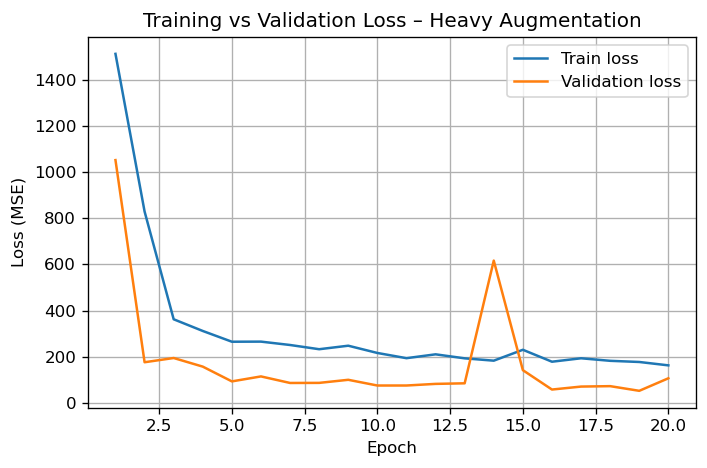

In [27]:
# draw a simple graph showing how the training loss and validation loss changed over the epochs when we trained the model with heavy augmentation. 
#It helps us see whether the model improved steadily and whether it overfitted or not.(Heavy augumentation)

import matplotlib.pyplot as plt

# If in your code they are called train_losses / val_losses, rename here:
# train_losses_aug = train_losses
# val_losses_aug = val_losses

epochs = range(1, len(train_losses_aug) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses_aug, label="Train loss")
plt.plot(epochs, val_losses_aug, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss – Heavy Augmentation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#The validation loss is lower, but the overall pattern suggests that this level of augmentation is too strong and does not benefit the modelis learning

In [17]:
#Train the best model (depth 5) multiple times using different learning rates to see which one works best. For each learning rate, it trains the model, keeps the best version based on validation RMSE, then evaluates that version on the test set. 
#The results are stored so we can compare how each learning rate performed

lrs_to_try = [1e-4, 3e-4, 1e-3, 3e-3]
EPOCHS_LR = 15

lr_results = []

for lr in lrs_to_try:
    print("=" * 80)
    print(f"Training depth 5 with LR = {lr}")
    print("=" * 80)

    model_lr = SteeringCNNDepth(
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        in_channels=3,
        num_conv_layers=BEST_DEPTH
    ).to(DEVICE)

    optimizer_lr = optim.Adam(model_lr.parameters(), lr=lr, weight_decay=1e-4)

    best_val_rmse_lr = float("inf")
    best_state_lr = None

    for epoch in range(1, EPOCHS_LR + 1):
        train_loss = train_one_epoch(model_lr, train_loader_aug, optimizer_lr, criterion)
        val_loss, val_mae, val_rmse, val_r2, _, _ = evaluate(model_lr, val_loader_aug, criterion)

        print(
            f"LR {lr} | Epoch {epoch:02d}/{EPOCHS_LR} | "
            f"Train: {train_loss:.4f} | "
            f"Val: {val_loss:.4f} | "
            f"Val RMSE: {val_rmse:.4f} | "
            f"Val R2: {val_r2:.4f}"
        )

        if val_rmse < best_val_rmse_lr:
            best_val_rmse_lr = val_rmse
            best_state_lr = model_lr.state_dict()

    # Evaluate best on test
    if best_state_lr is not None:
        model_lr.load_state_dict(best_state_lr)

    test_loss_lr, test_mae_lr, test_rmse_lr, test_r2_lr, _, _ = evaluate(
        model_lr, test_loader_aug, criterion
    )

    lr_results.append({
        "lr": lr,
        "best_val_rmse": best_val_rmse_lr,
        "test_loss": test_loss_lr,
        "test_mae": test_mae_lr,
        "test_rmse": test_rmse_lr,
        "test_r2": test_r2_lr,
    })

lr_results_df = pd.DataFrame(lr_results)
display(lr_results_df.sort_values("test_rmse"))


Training depth 5 with LR = 0.0001
LR 0.0001 | Epoch 01/15 | Train: 2211.6900 | Val: 2115.2094 | Val RMSE: 45.9914 | Val R2: 0.0237
LR 0.0001 | Epoch 02/15 | Train: 1800.2169 | Val: 998.0241 | Val RMSE: 31.5915 | Val R2: 0.5394
LR 0.0001 | Epoch 03/15 | Train: 727.5421 | Val: 364.2247 | Val RMSE: 19.0847 | Val R2: 0.8319
LR 0.0001 | Epoch 04/15 | Train: 418.7184 | Val: 180.8494 | Val RMSE: 13.4480 | Val R2: 0.9165
LR 0.0001 | Epoch 05/15 | Train: 344.8305 | Val: 146.6308 | Val RMSE: 12.1091 | Val R2: 0.9323
LR 0.0001 | Epoch 06/15 | Train: 306.6758 | Val: 123.0597 | Val RMSE: 11.0932 | Val R2: 0.9432
LR 0.0001 | Epoch 07/15 | Train: 271.3853 | Val: 116.0174 | Val RMSE: 10.7711 | Val R2: 0.9465
LR 0.0001 | Epoch 08/15 | Train: 251.1340 | Val: 118.7176 | Val RMSE: 10.8958 | Val R2: 0.9452
LR 0.0001 | Epoch 09/15 | Train: 269.6806 | Val: 119.7259 | Val RMSE: 10.9419 | Val R2: 0.9447
LR 0.0001 | Epoch 10/15 | Train: 233.3691 | Val: 92.5551 | Val RMSE: 9.6206 | Val R2: 0.9573
LR 0.0001 | Epo

,lr,best_val_rmse,test_loss,test_mae,test_rmse,test_r2
2,0.0010,7.115326,75.004513,5.400256,8.660515,0.965403
0,0.0001,8.504961,90.832296,6.016796,9.530598,0.958102
1,0.0003,8.346821,94.177763,6.858297,9.704523,0.956559
3,0.0030,11.256930,191.990032,10.660021,13.856047,0.911441


In [ ]:
#We tuned the learning rate after adding augmentation because augmentation changes the training dynamics and can require a different optimal LR. 
#This ensures the learning rate is chosen specifically for the final training setup we actually use

In [ ]:
#3 phase

In [18]:
#a new version of SteeringDatasetAug with weaker augmentation. Images are still resized and normalised, but now brightness/contrast changes are smaller, rotation is reduced to about 3°, and shifts are only about 3% of the image. 
#It also filters out missing images as before and returns each image with its steering angle

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import torch
import os
from pathlib import Path

class SteeringDatasetAug(Dataset):
    """
    Dataset with optional, relatively mild data augmentation.
    - augment=False: only resize + normalize (for val/test)
    - augment=True : apply weaker jitter + small affine transforms (for train)
    """
    def __init__(self, dataframe, img_dir, image_column, angle_column,
                 img_height=66, img_width=200, augment=False):
        self.img_dir = Path(img_dir)
        self.df = dataframe.reset_index(drop=True)
        self.image_column = image_column
        self.angle_column = angle_column
        self.img_height = img_height
        self.img_width = img_width
        self.augment = augment

        # Always resize to network input size
        self.base_transform = T.Resize((self.img_height, self.img_width))

        # 🔻 Weaker augmentation than before:
        # - smaller brightness/contrast jitter
        # - smaller rotation + translation
        self.aug_transform = T.Compose([
            T.ColorJitter(
                brightness=0.15,   # was 0.3
                contrast=0.15,     # was 0.3
                saturation=0.1,
                hue=0.03
            ),
            T.RandomAffine(
                degrees=3,             # was 5
                translate=(0.03, 0.03) # was (0.05, 0.05)
            ),
        ])

        self.to_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5]),
        ])

        # Pre-filter valid samples like before
        self.samples = []
        missing = 0
        for _, row in self.df.iterrows():
            raw_path = str(row[self.image_column])
            filename = os.path.basename(raw_path)
            img_path = self.img_dir / filename
            if not img_path.exists():
                missing += 1
                continue
            angle = float(row[self.angle_column])
            self.samples.append((img_path, angle))

        print(f"SteeringDatasetAug(augment={augment}) – {len(self.samples)} valid samples, "
              f"skipped {missing} missing images.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, angle = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.base_transform(image)

        if self.augment:
            image = self.aug_transform(image)   # only for train

        image = self.to_tensor(image)
        angle_tensor = torch.tensor([angle], dtype=torch.float32)
        return image, angle_tensor


In [19]:
# rebuild the train, validation, and test loaders using the new softer augmentation (train only). Validation and test stay clean

train_dataset_aug = SteeringDatasetAug(
    train_df, IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
    img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
    augment=True
)

val_dataset_aug = SteeringDatasetAug(
    val_df, IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
    img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
    augment=False
)

test_dataset_aug = SteeringDatasetAug(
    test_df, IMG_DIR, IMAGE_COLUMN, ANGLE_COLUMN,
    img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
    augment=False
)

BATCH_SIZE = 32

train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2, pin_memory=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=2, pin_memory=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader_aug))
print("Val batches  :", len(val_loader_aug))
print("Test batches :", len(test_loader_aug))


SteeringDatasetAug(augment=True) – 2606 valid samples, skipped 0 missing images.
SteeringDatasetAug(augment=False) – 558 valid samples, skipped 0 missing images.
SteeringDatasetAug(augment=False) – 559 valid samples, skipped 0 missing images.
Train batches: 82
Val batches  : 18
Test batches : 18


In [21]:
#the depth 5 model for more epochs using the softer augmentation. It also uses a scheduler that automatically lowers the learning rate when validation performance stops improving. 
#The best version of the model is saved and later evaluated on the test set, and the final metrics are printed.

criterion = nn.MSELoss()

LR_SCHED = 1e-3
EPOCHS_SCHED = 35          # more epochs than before
PATIENCE = 5                # how many epochs with no improvement before LR is reduced
FACTOR = 0.5                # LR_new = LR_old * FACTOR

model_scheduled = SteeringCNNDepth(
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    in_channels=3,
    num_conv_layers=BEST_DEPTH  # 5
).to(DEVICE)

optimizer = torch.optim.Adam(
    model_scheduled.parameters(),
    lr=LR_SCHED,
    weight_decay=1e-4
)

# Scheduler monitors validation RMSE and reduces LR when it stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",        # we want to MINIMIZE val RMSE
    factor=FACTOR,
    patience=PATIENCE
)


best_val_rmse = float("inf")
best_state = None

train_losses_sched = []
val_losses_sched = []
val_rmses_sched  = []
lrs_over_time    = []

for epoch in range(1, EPOCHS_SCHED + 1):
    # record current LR
    current_lr = optimizer.param_groups[0]["lr"]
    lrs_over_time.append(current_lr)

    train_loss = train_one_epoch(model_scheduled, train_loader_aug, optimizer, criterion)
    val_loss, val_mae, val_rmse, val_r2, _, _ = evaluate(model_scheduled, val_loader_aug, criterion)

    train_losses_sched.append(train_loss)
    val_losses_sched.append(val_loss)
    val_rmses_sched.append(val_rmse)

    print(
        f"Epoch {epoch:02d}/{EPOCHS_SCHED} | "
        f"LR: {current_lr:.6f} | "
        f"Train: {train_loss:.4f} | "
        f"Val: {val_loss:.4f} | "
        f"Val RMSE: {val_rmse:.4f} | "
        f"Val R2: {val_r2:.4f}"
    )

    # Step scheduler using validation RMSE
    scheduler.step(val_rmse)

    # Keep best model by RMSE
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = model_scheduled.state_dict()

# Load best state and evaluate on test set
if best_state is not None:
    model_scheduled.load_state_dict(best_state)

test_loss_sched, test_mae_sched, test_rmse_sched, test_r2_sched, _, _ = evaluate(
    model_scheduled, test_loader_aug, criterion
)

print("\n== Scheduled model (depth 5, weaker aug, LR=1e-3 with ReduceLROnPlateau) ==")
print(f"Best Val RMSE: {best_val_rmse:.4f}")
print(f"Test Loss: {test_loss_sched:.4f}")
print(f"Test MAE : {test_mae_sched:.4f}")
print(f"Test RMSE: {test_rmse_sched:.4f}")
print(f"Test R2  : {test_r2_sched:.4f}")


Epoch 01/35 | LR: 0.001000 | Train: 1010.2775 | Val: 156.8639 | Val RMSE: 12.5245 | Val R2: 0.9276
Epoch 02/35 | LR: 0.001000 | Train: 282.6308 | Val: 114.6140 | Val RMSE: 10.7058 | Val R2: 0.9471
Epoch 03/35 | LR: 0.001000 | Train: 242.7217 | Val: 100.1441 | Val RMSE: 10.0072 | Val R2: 0.9538
Epoch 04/35 | LR: 0.001000 | Train: 203.5733 | Val: 84.8001 | Val RMSE: 9.2087 | Val R2: 0.9609
Epoch 05/35 | LR: 0.001000 | Train: 213.3920 | Val: 112.4620 | Val RMSE: 10.6048 | Val R2: 0.9481
Epoch 06/35 | LR: 0.001000 | Train: 181.5831 | Val: 78.4891 | Val RMSE: 8.8594 | Val R2: 0.9638
Epoch 07/35 | LR: 0.001000 | Train: 170.9842 | Val: 122.7953 | Val RMSE: 11.0813 | Val R2: 0.9433
Epoch 08/35 | LR: 0.001000 | Train: 195.1469 | Val: 95.6506 | Val RMSE: 9.7801 | Val R2: 0.9559
Epoch 09/35 | LR: 0.001000 | Train: 154.0793 | Val: 70.3030 | Val RMSE: 8.3847 | Val R2: 0.9676
Epoch 10/35 | LR: 0.001000 | Train: 163.8008 | Val: 65.7421 | Val RMSE: 8.1081 | Val R2: 0.9697
Epoch 11/35 | LR: 0.001000 | 

In [26]:
# GPU NOTEBOOK : SAVE MODEL AS "model_weights" 

import os
import torch

# 1. Choose the model to save (augmented weak + scheduler 5-layer)
best_model = model_scheduled           


best_model.cpu()


save_path = os.path.expanduser("~/notebooks/model_weights")


torch.save(best_model.state_dict(), save_path)

print("Saved model weights to:", save_path)


Saved model weights to: /home/s25076817/notebooks/model_weights


In [31]:
#Although the non-augmented model originally gave the best test score, we chose to use this depth-5 model with a lower learning rate and weak augmentation because it behaves more realistically 
#when driving the robot. 

#This version was saved as the final model and deployed on the robot, since the mild augmentation helps it generalize better to small lighting and position changes in real conditions.

In [32]:
#Clarification:By heavy augmentation, we mean strong image changes like big colour shifts and larger rotations that make the data look less realistic. 
#By weak augmentation, we mean small, natural variations that better match real driving conditions.